In [1]:
import os
from os.path import isdir, exists, join
import nibabel as nib
from matplotlib import pyplot as plt
import torchio as tio
from multiprocessing import Pool


/labs/gevaertlab/users/thomas/miniconda/envs/multimodal/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create dummy brain masks

In [ ]:
from tqdm import tqdm

DATA_DIR = "../data/MR/UKBIOBANK"
cases = [f for f in os.listdir(DATA_DIR) if isdir(join(DATA_DIR, f))]

def create_mask(case):
    if not exists(join(DATA_DIR, case, "brain_mask.nii.gz")):
        print(f"\nProcessing {case}")
        t1_path = [join(DATA_DIR, case,f) for f in os.listdir(join(DATA_DIR, case)) if "t1" in f.lower()][0]
        img = nib.load(t1_path)
        brain_mask = (img.get_fdata() > 1)
        brain_mask = brain_mask.astype(float)
        final_brain_mask = nib.Nifti1Image(brain_mask, img.affine)  
        nib.save(final_brain_mask, join(DATA_DIR, case, "brain_mask.nii.gz"))
    else:
        print(f"\n{case} Already masked.")


pool = Pool(20)
pool.map(create_mask, cases)

# Viewer

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio

# img = nib.load("/home/tbarba/projects/MultiModalBrainSurvival/data/MR/REMBRANDT/HF1139/HF1139_flair.nii")
img = nib.load(
    "/home/tbarba/projects/MultiModalBrainSurvival/data/MR/UCSF/UCSF-PDGM-0541/UCSF-PDGM-0541_tumor_segmentation.nii.gz")

resample = tio.Resample(1, image_interpolation='linear')
rescale = tio.RescaleIntensity(out_min_max=(0,255.0))

img = resample(img)
img = rescale(img)
img = img.get_fdata()
slice = img[:,:,30]
plt.imshow(slice, cmap="Greys_r")

# img.min()

/labs/gevaertlab/users/thomas/miniconda/envs/multimodal/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImageFileError: Empty file: '/home/tbarba/projects/MultiModalBrainSurvival/data/MR/UCSF/UCSF-PDGM-0541/UCSF-PDGM-0541_tumor_segmentation.nii.gz'

(155, 240, 240)


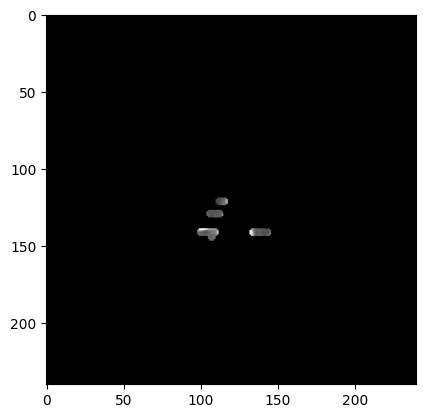

In [67]:
# img = img.transpose((2, 1, 0))
print(img.shape)
slice = img[154,:,:]
plt.imshow(slice, cmap="Greys_r")


# Create binned survival TCGA

In [2]:
import pandas as pd
n=4
df = pd.read_csv("../data/metadata/TCGA_metadata.csv", index_col="case")
df['survival_bin'] = pd.qcut(df['survival_months'], n, labels = [x for x in range(n)])
df['survival_bin'].value_counts()

df.to_csv("../data/metadata/TCGA_metadata.csv", index=True)


# TCGA Genetics

In [47]:
import pandas as pd
import json

TCGA_meta = pd.read_csv("/home/tbarba/projects/MultiModalBrainSurvival/data/metadata/TCGA_survival_data.csv")


files = ["R132H.json", "R132C.json","R132G.json","R132S.json"]

dict_muts = dict()
for file in files:
    with open(file, "r") as mutation:
        mut = file[:-5]
        mutation=  json.load(mutation)
        mutation = {mutation[c]["submitter_id"]:mut for c in range(len(mutation))}
        dict_muts.update(mutation)

IDH1_mutations = []
for i, row in TCGA_meta.iterrows():
    try:
        IDH1_mutations.append(dict_muts[TCGA_meta.iloc[i]["case"]])
    except KeyError:
        IDH1_mutations.append("WT")

TCGA_meta['IDH1']  = IDH1_mutations
TCGA_meta['IDH1_bin'] = TCGA_meta['IDH1'] != "WT"

TCGA_meta.to_csv("/home/tbarba/projects/MultiModalBrainSurvival/data/metadata/TCGA_survival_data.csv", index=False)



# RENAME UCSF

In [10]:
import os
from os.path import join
def ls_dir(path):
    dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    return dirs


ROOT = "/home/tbarba/projects/MultiModalBrainSurvival/data/MR/UCSF"
dirs = ls_dir(ROOT)


for folder in dirs:
    old = join(ROOT, folder)
    new = join(ROOT, folder.replace("_nifti", ""))
    os.rename(old, new)


# BrainExtractor

(241, 241, 161)
(241, 241, 161)


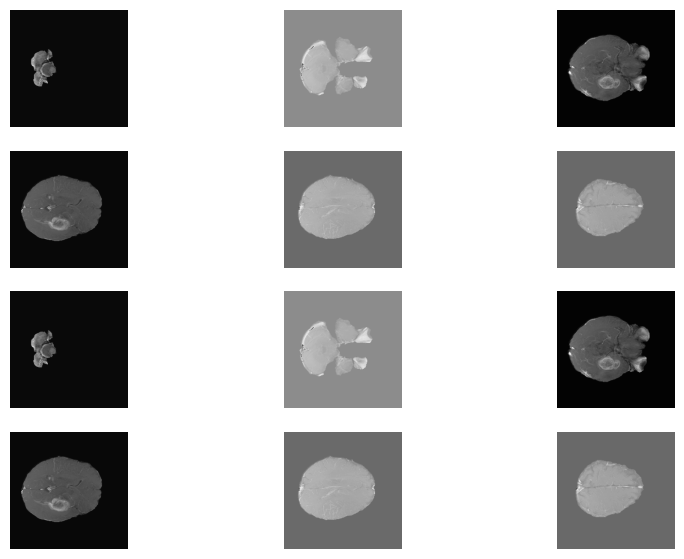

In [48]:
from os.path import join
from matplotlib import pyplot as plt
import nibabel as nib
import torchio as tio

N = 4
DATA = f"/home/tbarba/projects/MultiModalBrainSurvival/data/MR/STANFORD/Patient-0{N}"
flair = join(DATA, "FLAIR.nii.gz")
t1 = join(DATA, "T1Gd.nii.gz")

maskedT = join(DATA, "0-masked-T1Gd.nii.gz")
maskedF = join(DATA, "0-masked-FLAIR.nii.gz")
resample = tio.Resample(1, image_interpolation='bspline')

slices = [10, 40, 60, 80, 100, 120]

fig = plt.figure(figsize=(10, 7))
i =1
for m in [maskedT, maskedT]:

    img = nib.load(m)
    # img = resample(img)

    img = img.get_fdata()
    print(img.shape)
    for _, s in enumerate(slices):
        fig.add_subplot(4, 3, i)
        plt.imshow(img[:,:,s], cmap="Greys_r")
        plt.axis("off")
        i+=1